# Multi-Seed Late Fusion with Weighted Fusion (Post Features)

This notebook runs late fusion across multiple random seeds with focus on POST-submit physiological features.


In [1]:
import pickle
import json
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')


## 1. Load Pre-Extracted Features


In [2]:
# Load pre-extracted features
with open('../../data/results/features_PRE/extracted_features_PRE.pkl', 'rb') as f:
    feature_data = pickle.load(f)

merged_df = feature_data['merged_df']
physio_cols = feature_data['physio_cols']
behavior_cols = feature_data['behavior_cols']
gaze_cols = feature_data['gaze_cols']

print(f"✓ Loaded {len(merged_df)} trials from {merged_df['subject_id'].nunique()} subjects")
print(f"  Features extracted on: {feature_data['metadata']['extraction_date']}")
print(f"  Baseline method: {feature_data['metadata']['baseline_method']}")
print(f"\nFeature counts:")
print(f"  Physiology (PRE): {len(physio_cols)} features")
print(f"  Behavior: {len(behavior_cols)} features")
print(f"  Gaze: {len(gaze_cols)} features")
print(f"\nOutcome distribution:")
print(merged_df['outcome'].value_counts())


def weighted_late_fusion(X_modalities, y, subjects, modality_names, random_seed):
    """
    Weighted late fusion with specific random seed.
    Returns subject-level accuracy for proper error calculation.
    """
    logo = LeaveOneGroupOut()
    base_models = [RandomForestClassifier(n_estimators=100, max_depth=5, 
                                          min_samples_split=10, min_samples_leaf=5, 
                                          random_state=random_seed)
                   for _ in X_modalities]
    
    # Store subject-level results
    subject_accs = {}  # subject_id -> accuracy
    subject_f1s = {}   # subject_id -> f1_score
    all_weights = []
    preds_all, y_true_all = [], []
    
    for train_idx, test_idx in logo.split(X_modalities[0], y, subjects):
        # Train base models and get probabilities
        train_probs, test_probs = [], []
        
        for X, model in zip(X_modalities, base_models):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train = y[train_idx]
            
            model.fit(X_train, y_train)
            train_probs.append(model.predict_proba(X_train)[:, 1])
            test_probs.append(model.predict_proba(X_test)[:, 1])
        
        train_probs = np.column_stack(train_probs)
        test_probs = np.column_stack(test_probs)
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Weighted fusion via logistic regression
        meta = LogisticRegression(random_state=random_seed, max_iter=1000)
        meta.fit(train_probs, y_train)
        weights = meta.coef_[0]
        y_pred = meta.predict(test_probs)
        
        # Calculate metrics for this subject (fold)
        test_subject = subjects[test_idx][0]  # All test samples are from same subject
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        subject_accs[test_subject] = acc
        subject_f1s[test_subject] = f1
        all_weights.append(weights)
        preds_all.extend(y_pred)
        y_true_all.extend(y_test)
    
    # Convert subject-level results to arrays
    subject_acc_values = np.array(list(subject_accs.values()))
    subject_f1_values = np.array(list(subject_f1s.values()))
    
    avg_weights = np.mean(all_weights, axis=0)
    norm_weights = np.exp(avg_weights) / np.sum(np.exp(avg_weights))
    
    return {
        'seed': random_seed,
        'accuracy_mean': np.mean(subject_acc_values),
        'accuracy_sem': stats.sem(subject_acc_values),  # Standard Error of the Mean
        'accuracy_std': np.std(subject_acc_values),      # Standard Deviation
        'accuracy_per_subject': subject_acc_values,      # Individual subject accuracies
        'f1_mean': np.mean(subject_f1_values),
        'f1_sem': stats.sem(subject_f1_values),
        'f1_std': np.std(subject_f1_values),
        'f1_per_subject': subject_f1_values,
        'weights': norm_weights,
        'modality_names': modality_names,
        'n_subjects': len(subject_accs),
    }


✓ Loaded 12511 trials from 97 subjects
  Features extracted on: 2025-12-27 14:10:40
  Baseline method: t3_stable_pre_decision

Feature counts:
  Physiology (PRE): 13 features
  Behavior: 7 features
  Gaze: 20 features

Outcome distribution:
outcome
1    8238
0    4273
Name: count, dtype: int64


## 2. Prepare Feature Sets


In [3]:
# Prepare feature arrays for model training
X_physio = SimpleImputer(strategy='mean').fit_transform(merged_df[physio_cols])
X_behavior = SimpleImputer(strategy='mean').fit_transform(merged_df[behavior_cols])
X_gaze = SimpleImputer(strategy='mean').fit_transform(merged_df[gaze_cols])
y = merged_df['outcome'].values
subjects = merged_df['subject_id'].values

print(f"Shapes: X_physio={X_physio.shape}, X_behavior={X_behavior.shape}, X_gaze={X_gaze.shape}")


Shapes: X_physio=(12511, 13), X_behavior=(12511, 7), X_gaze=(12511, 20)


## 3. Run Multi-Seed Analysis


In [4]:
# Run multiple seeds
SEEDS = [42, 123, 456, 789, 1024, 2048, 3141, 5678, 8888, 9999]
X_modalities = [X_physio, X_behavior, X_gaze]
modality_names = ['Physiology (PRE)', 'Behavior', 'Gaze']

results = []
for seed in SEEDS:
    print(f"\nRunning seed {seed}...")
    result = weighted_late_fusion(X_modalities, y, subjects, modality_names, seed)
    results.append(result)
    print(f"  Accuracy: {result['accuracy_mean']:.3f} ± {result['accuracy_sem']:.3f} (SEM) / ± {result['accuracy_std']:.3f} (SD)")
    print(f"  F1-Score: {result['f1_mean']:.3f} ± {result['f1_sem']:.3f} (SEM)")
    print(f"  N subjects: {result['n_subjects']}")
    print(f"  Weights: {result['weights']}")



Running seed 42...
  Accuracy: 0.682 ± 0.014 (SEM) / ± 0.139 (SD)
  F1-Score: 0.666 ± 0.016 (SEM)
  N subjects: 97
  Weights: [0.00658755 0.05226688 0.94114556]

Running seed 123...
  Accuracy: 0.685 ± 0.014 (SEM) / ± 0.140 (SD)
  F1-Score: 0.669 ± 0.016 (SEM)
  N subjects: 97
  Weights: [0.00631409 0.05037883 0.94330709]

Running seed 456...
  Accuracy: 0.684 ± 0.014 (SEM) / ± 0.141 (SD)
  F1-Score: 0.668 ± 0.016 (SEM)
  N subjects: 97
  Weights: [0.00516421 0.03812465 0.95671113]

Running seed 789...
  Accuracy: 0.686 ± 0.014 (SEM) / ± 0.139 (SD)
  F1-Score: 0.671 ± 0.016 (SEM)
  N subjects: 97
  Weights: [0.00473082 0.0317203  0.96354888]

Running seed 1024...
  Accuracy: 0.685 ± 0.014 (SEM) / ± 0.141 (SD)
  F1-Score: 0.669 ± 0.016 (SEM)
  N subjects: 97
  Weights: [0.00585828 0.04457205 0.94956966]

Running seed 2048...
  Accuracy: 0.684 ± 0.014 (SEM) / ± 0.142 (SD)
  F1-Score: 0.669 ± 0.016 (SEM)
  N subjects: 97
  Weights: [0.00580942 0.03797262 0.95621796]

Running seed 3141...

## 4. Aggregate Results Across Seeds


In [5]:
# Create summary DataFrame
summary_df = pd.DataFrame([
    {
        'Seed': r['seed'],
        'Accuracy': r['accuracy_mean'],
        'Accuracy_SEM': r['accuracy_sem'],
        'Accuracy_SD': r['accuracy_std'],
        'F1-Score': r['f1_mean'],
        'F1_SEM': r['f1_sem'],
        'F1_SD': r['f1_std'],
        'Physiology_Weight': r['weights'][0],
        'Behavior_Weight': r['weights'][1],
        'Gaze_Weight': r['weights'][2]
    }
    for r in results
])

print("\n" + "="*80)
print("MULTI-SEED RESULTS SUMMARY")
print("="*80)
print(summary_df[['Seed', 'Accuracy', 'Accuracy_SEM', 'Accuracy_SD', 'F1-Score', 'F1_SEM']].to_string(index=False))

print("\n" + "="*80)
print("AGGREGATE STATISTICS (using SEM for error bars)")
print("="*80)
print(f"Mean Accuracy: {summary_df['Accuracy'].mean():.3f} ± {summary_df['Accuracy_SEM'].mean():.3f} (avg SEM)")
print(f"Mean F1-Score: {summary_df['F1-Score'].mean():.3f} ± {summary_df['F1_SEM'].mean():.3f} (avg SEM)")
print(f"\nMean Modality Weights:")
print(f"  Physiology (PRE): {summary_df['Physiology_Weight'].mean():.3f} ± {summary_df['Physiology_Weight'].std():.3f}")
print(f"  Behavior:          {summary_df['Behavior_Weight'].mean():.3f} ± {summary_df['Behavior_Weight'].std():.3f}")
print(f"  Gaze:              {summary_df['Gaze_Weight'].mean():.3f} ± {summary_df['Gaze_Weight'].std():.3f}")

print("\n" + "="*80)
print("NOTE: SEM (Standard Error of Mean) is computed from subject-level accuracies")
print("SEM = SD / sqrt(n_subjects), where n_subjects = 10")
print("="*80)



MULTI-SEED RESULTS SUMMARY
 Seed  Accuracy  Accuracy_SEM  Accuracy_SD  F1-Score   F1_SEM
   42  0.681951      0.014160     0.138736  0.666136 0.016182
  123  0.685401      0.014287     0.139981  0.669359 0.016307
  456  0.683570      0.014436     0.141443  0.667685 0.016452
  789  0.686320      0.014180     0.138935  0.670937 0.016168
 1024  0.685093      0.014405     0.141136  0.669419 0.016365
 2048  0.684169      0.014497     0.142042  0.668905 0.016459
 3141  0.682392      0.014359     0.140692  0.666402 0.016432
 5678  0.685581      0.014191     0.139042  0.669080 0.016423
 8888  0.684003      0.014324     0.140350  0.667813 0.016392
 9999  0.685692      0.014347     0.140571  0.669823 0.016341

AGGREGATE STATISTICS (using SEM for error bars)
Mean Accuracy: 0.684 ± 0.014 (avg SEM)
Mean F1-Score: 0.669 ± 0.016 (avg SEM)

Mean Modality Weights:
  Physiology (PRE): 0.006 ± 0.001
  Behavior:          0.043 ± 0.007
  Gaze:              0.952 ± 0.008

NOTE: SEM (Standard Error of Mean)

## 5. Visualizations


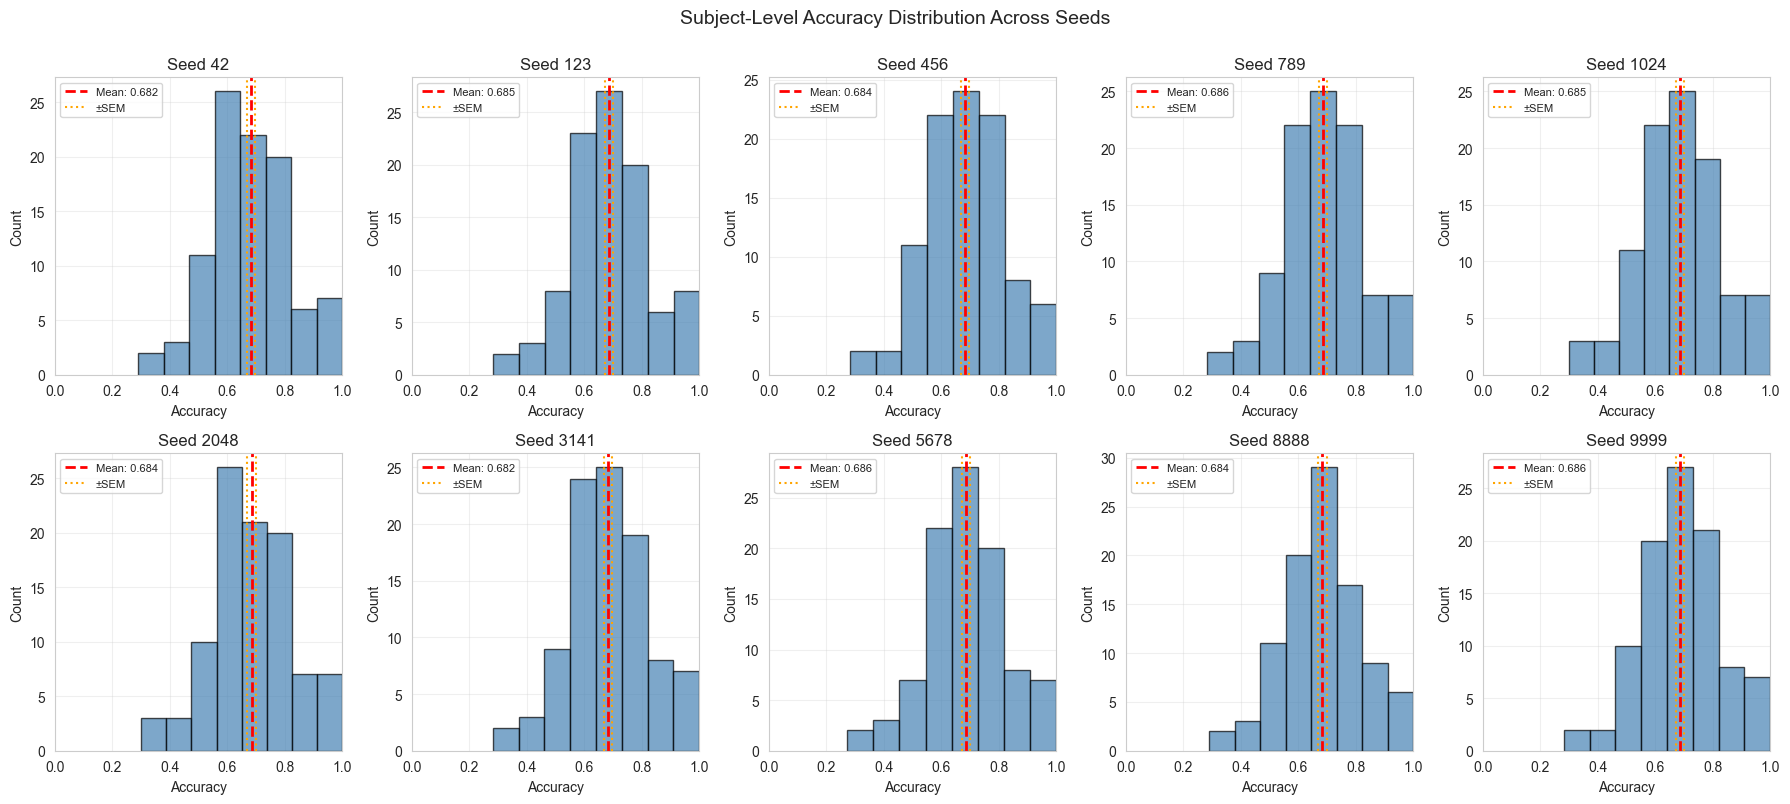

In [6]:
# Plot distribution of subject-level accuracies
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for idx, result in enumerate(results):
    ax = axes[idx]
    subject_accs = result['accuracy_per_subject']
    
    # Histogram
    ax.hist(subject_accs, bins=8, color='steelblue', alpha=0.7, edgecolor='black')
    ax.axvline(result['accuracy_mean'], color='red', linestyle='--', linewidth=2, 
               label=f"Mean: {result['accuracy_mean']:.3f}")
    ax.axvline(result['accuracy_mean'] - result['accuracy_sem'], color='orange', 
               linestyle=':', linewidth=1.5, label=f"±SEM")
    ax.axvline(result['accuracy_mean'] + result['accuracy_sem'], color='orange', 
               linestyle=':', linewidth=1.5)
    
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Count')
    ax.set_title(f'Seed {result["seed"]}')
    ax.set_xlim([0, 1])
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

plt.suptitle('Subject-Level Accuracy Distribution Across Seeds', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()


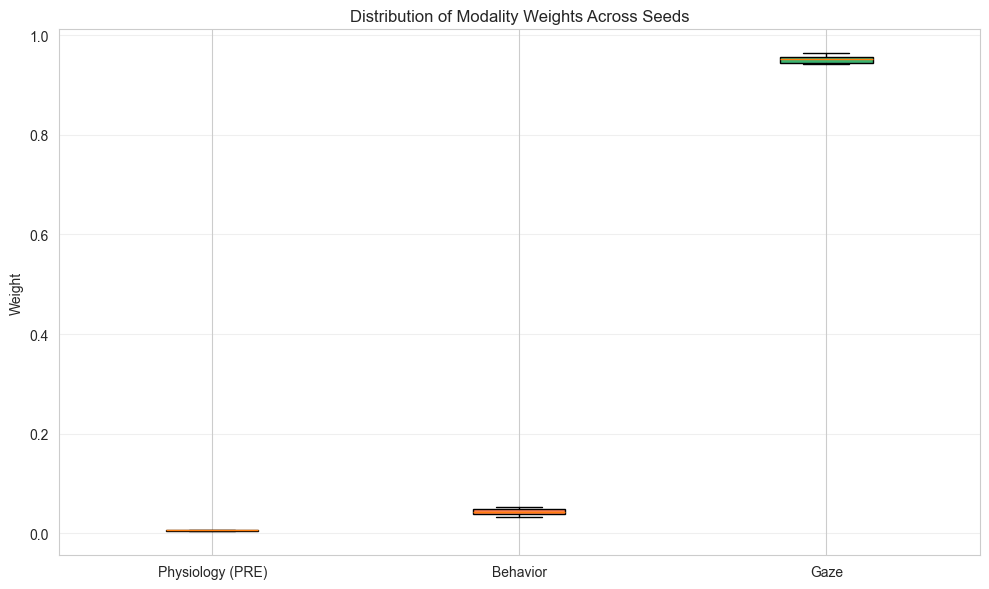

In [7]:
# Box plots of weights
fig, ax = plt.subplots(figsize=(10, 6))

weight_data = [
    summary_df['Physiology_Weight'].values,
    summary_df['Behavior_Weight'].values,
    summary_df['Gaze_Weight'].values
]

bp = ax.boxplot(weight_data, labels=modality_names, patch_artist=True)
colors = ['steelblue', 'coral', 'mediumseagreen']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel('Weight')
ax.set_title('Distribution of Modality Weights Across Seeds')
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


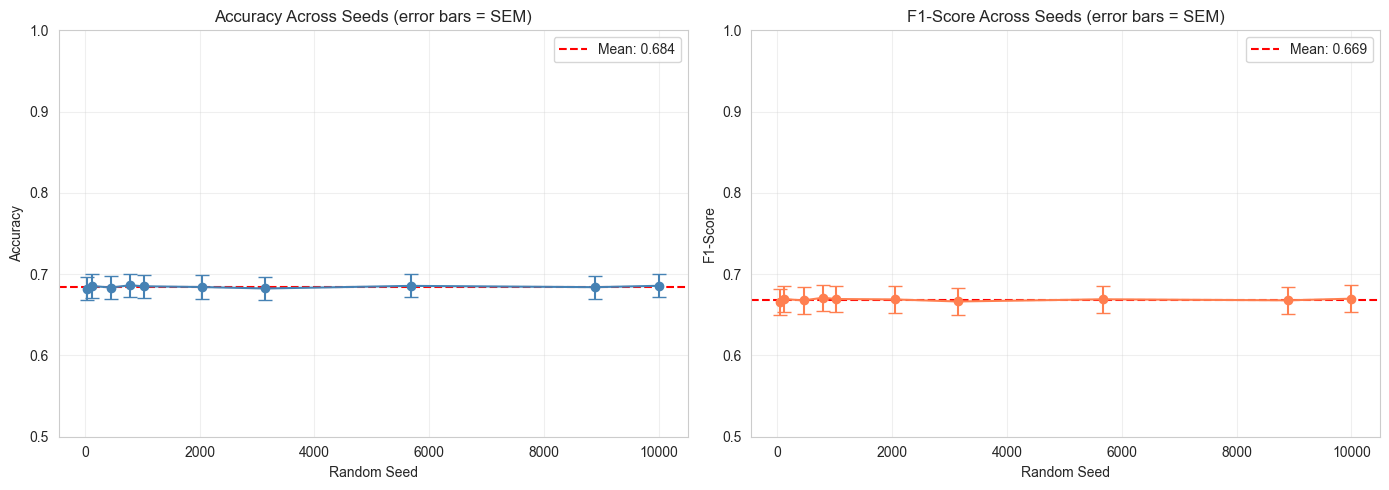

In [8]:
# Performance across seeds with SEM error bars
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.errorbar(summary_df['Seed'], summary_df['Accuracy'], 
            yerr=summary_df['Accuracy_SEM'], fmt='o-', capsize=5, color='steelblue')
ax.axhline(summary_df['Accuracy'].mean(), color='red', linestyle='--', 
           label=f"Mean: {summary_df['Accuracy'].mean():.3f}")
ax.set_xlabel('Random Seed')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Across Seeds (error bars = SEM)')
ax.set_ylim([0.5, 1.0])
ax.legend()
ax.grid(alpha=0.3)

ax = axes[1]
ax.errorbar(summary_df['Seed'], summary_df['F1-Score'], 
            yerr=summary_df['F1_SEM'], fmt='o-', capsize=5, color='coral')
ax.axhline(summary_df['F1-Score'].mean(), color='red', linestyle='--', 
           label=f"Mean: {summary_df['F1-Score'].mean():.3f}")
ax.set_xlabel('Random Seed')
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score Across Seeds (error bars = SEM)')
ax.set_ylim([0.5, 1.0])
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Class Distribution Analysis


In [9]:
# Analyze class distribution per subject
print("\n" + "="*80)
print("CLASS DISTRIBUTION PER SUBJECT")
print("="*80)

subject_class_dist = merged_df.groupby(['subject_id', 'outcome']).size().unstack(fill_value=0)
subject_class_dist['Total'] = subject_class_dist.sum(axis=1)
subject_class_dist['INVEST_pct'] = (subject_class_dist[1] / subject_class_dist['Total'] * 100).round(1)
subject_class_dist['KEEP_pct'] = (subject_class_dist[0] / subject_class_dist['Total'] * 100).round(1)

print(subject_class_dist.to_string())

print(f"\n{'='*80}")
print("SUMMARY:")
print(f"Mean trials per subject: {subject_class_dist['Total'].mean():.1f}")
print(f"Std trials per subject: {subject_class_dist['Total'].std():.1f}")
print(f"Mean INVEST %: {subject_class_dist['INVEST_pct'].mean():.1f}%")
print(f"Std INVEST %: {subject_class_dist['INVEST_pct'].std():.1f}%")



CLASS DISTRIBUTION PER SUBJECT
outcome              0    1  Total  INVEST_pct  KEEP_pct
subject_id                                              
0806_1000_539136F   38   80    118        67.8      32.2
0806_1000_U9TEJGM   59   72    131        55.0      45.0
0811_1000_4LI8GO7   27   94    121        77.7      22.3
0811_1000_539136F   27  103    130        79.2      20.8
0811_1000_U9TEJGM   38   93    131        71.0      29.0
0813_1000_539136F   77   52    129        40.3      59.7
0813_1000_9M4VCHG   59   64    123        52.0      48.0
0813_1000_U9TEJGM   61   67    128        52.3      47.7
0813_1600_539136F   44   80    124        64.5      35.5
0813_1600_9M4VCHG   52   78    130        60.0      40.0
0813_1600_U9TEJGM   17  106    123        86.2      13.8
0816_1400_539136F   17  112    129        86.8      13.2
0816_1400_9M4VCHG   77   47    124        37.9      62.1
0816_1400_U9TEJGM   38   87    125        69.6      30.4
0817_1000_539136F   57   74    131        56.5      43.5